In [2]:
import os
import sys; sys.path.append("../")
import pickle
from network_model import *
from SALib.sample import sobol, saltelli
from tqdm import tqdm


import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({"font.size" : 15,
                     "figure.dpi" : 100, 
                     "grid.alpha" : 0.3, 
                     "axes.grid": True, 
                     "axes.axisbelow" : True,
                     "figure.figsize":(8,6),
                     "mathtext.fontset":"cm",
                     "xtick.labelsize": 14,
                     "ytick.labelsize": 14,
                     "axes.labelsize": 16, 
                     "legend.fontsize": 13.5})
USE_TEX = False
if USE_TEX:
    plt.rc("text", usetex=True)
    plt.rc("text.latex", preamble=r"""
     \usepackage{times}
     \usepackage{mathptmx}""")
else:
    plt.rc("text", usetex=False)
plt.rc("font", family="serif")

In [42]:
def sda_prob(d, a, b):
    return 1 / (1 + ((1/b)*d)**a)


def sda_graph(P):
    G = nx.Graph()
    # create nodes
    for i in range(1250):
        G.add_node(i)
    coin_flips = np.random.uniform(size=780625) # 780625 = number of pairwise distances for 1250 agents
    k = 0
    # add edges probabilistically
    for i in range(len(P)):
        for j in range(i+1, len(P)):
            if P[i][j] > coin_flips[k]:
                G.add_edge(i,j)
            k += 1  
    return G

# Saltelli sampling

In [66]:
# problem definition
PROBLEM = {
    "num_vars" : 7,
    "names"    : ["project_cost",
                  "gain_right",
                  "alpha_beta",
                  "prob_left",
                  "init_w_scale",
                  "risk_scale",
                  "poisson_scale"],
    "bounds"   : [[0.01, 2.00],
                  [1.70, 2.30],
                  [0.70, 0.80],
                  [0.30, 0.45],
                  [0.01, 0.15],
                  [5.00, 20.0],
                  [8.00, 20.0]]
}

# generate Saltelli samples
NUM_SAMPLES = 1024
X = saltelli.sample(PROBLEM, NUM_SAMPLES, calc_second_order=False)

unique_w_scales = sorted(list(set(X[:,4])))

/var/folders/bj/4q98hxqx4vq6wwm8qqllvxmr0000gn/T/ipykernel_18063/173000835.py:22: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  X = saltelli.sample(PROBLEM, NUM_SAMPLES, calc_second_order=False)


# Generate graphs

In [67]:
# set random seed
random.seed(123)
np.random.seed(123)

for scale in tqdm(unique_w_scales):

    # create random initial wealth distribution
    W = np.random.normal(1, scale, size=1250)

    # compute pairwise distances
    pairwise_distances = []
    for i in range(len(W)):
        for j in range(i+1, len(W)):
            pairwise_distances.append(np.abs(W[i]-W[j]))
    mean_dist = np.mean(pairwise_distances)

    # SDA graph parameters
    a = 16
    b = mean_dist/15
    prob_attach = np.zeros((1250,1250))
    k = 0
    for i in range(len(W)):
        for j in range(i+1, len(W)):
            p = sda_prob(pairwise_distances[k], a=a, b=b)
            prob_attach[i][j] = p
            prob_attach[j][i] = p
            k+=1
    G = sda_graph(prob_attach)

    # ensure that graph is connected
    connected_components = list(nx.connected_components(G))
    largest_component = list(connected_components[0])
    largest_component_wealths = W[np.array(largest_component)]
    for i in range(1, len(connected_components)):
        comp = list(connected_components[i])
        node = np.random.choice(comp)
        closest_largest_component_node = (np.abs(largest_component_wealths - W[node])).argmin()
        G.add_edge(node, largest_component[closest_largest_component_node])
    assert nx.is_connected(G)

    # extract communities and construct community membership dictionary
    communities = get_communities(G)
    community_membership = get_community_membership(G, communities)

    # store results
    data_tuple = (G, communities, community_membership, W)
    with open(f"./sda_graphs/{scale}.pickle", "wb") as f:
        pickle.dump(data_tuple, f)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1024/1024 [23:42<00:00,  1.39s/it]


# Visualize graph distributions

In [89]:
green_colors = [
    (0.63137254901960782,  0.85098039215686272,  0.60784313725490191),
    (0.45490196078431372,  0.7686274509803922 ,  0.46274509803921571),
    (0.25490196078431371,  0.6705882352941176 ,  0.36470588235294116),
    (0.13725490196078433,  0.54509803921568623,  0.27058823529411763),
][::-1]

In [78]:
graph_data = []
for file in tqdm(os.listdir("../data/sda_graphs/")):
    with open("../data/sda_graphs/" + file, "rb") as f:
        data = pickle.load(f)
    graph_data.append(data)

100%|██████████| 1024/1024 [00:56<00:00, 18.02it/s]


In [94]:
num_communities = []
comm_sizes = []
indiv_degrees = []
comm_degrees = []

for item in tqdm(graph_data):
    
    # unpack tuple
    G, communities, community_membership, W = item
    
    # number of communities
    num_communities.append(len(communities))
    
    # sizes of communities
    augmented_communities = {}
    for agent in community_membership:
        comms = community_membership[agent]
        for c in comms:
            if c not in augmented_communities:
                augmented_communities[c] = {agent}
            else:
                augmented_communities[c].add(agent)
    augmented_communities = {k:np.array(list(v)) for k,v in augmented_communities.items()}
    largest_key = max(augmented_communities.keys())
    del augmented_communities[largest_key]
    comm_sizes += [len(x) for x in list(augmented_communities.values())]
    
    # individual degrees
    degrees = list(dict(G.degree).values())
    indiv_degrees += degrees
    
    # community degrees
    adjacency = dict((n, set(nbrdict.keys())) for n, nbrdict in G.adjacency())
    node_community_map = get_node_community_map(communities)
    community_adjacency = {}
    for i,c in enumerate(communities):
        community_adjacency[i] = set()
        for node in c:
            node_neighbours = adjacency[node]
            for neighbour in node_neighbours:
                neighbouring_community = node_community_map[neighbour]
                if neighbouring_community != i:
                    community_adjacency[i].add(neighbouring_community)
            
    # plot community degree distribution
    comm_degrees += [len(x) for x in list(community_adjacency.values())]

100%|██████████| 1024/1024 [00:31<00:00, 32.26it/s]


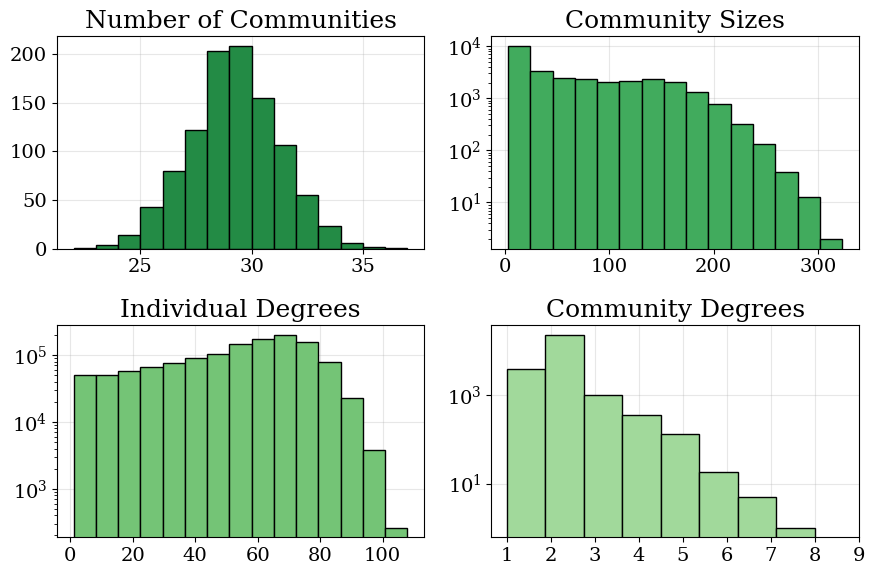

In [95]:
fig, axs = plt.subplots(2, 2, figsize=(9,6))

# number of communities
axs[0][0].hist(num_communities, bins=15, edgecolor="k", color=green_colors[0])
axs[0][0].set_title("Number of Communities")

# sizes of communities
axs[0][1].hist(comm_sizes, bins=15, edgecolor="k", color=green_colors[1])
axs[0][1].set_yscale("log")
axs[0][1].set_title("Community Sizes")

# individual degrees
axs[1][0].hist(indiv_degrees, bins=15, edgecolor="k", color=green_colors[2])
axs[1][0].set_yscale("log")
axs[1][0].set_title("Individual Degrees")

# community degrees
axs[1][1].hist(comm_degrees, bins=8, edgecolor="k", color=green_colors[3])
axs[1][1].set_yscale("log")
axs[1][1].set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9])
axs[1][1].set_title("Community Degrees")

fig.tight_layout()
plt.savefig("../figures/sda_graph_results.pdf", bbox_inches="tight")
plt.show()